In [1]:
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr
import multiprocessing as mp
import matplotlib.pyplot as plt
import copy
import matplotlib.colors as mcolors

import matplotlib.lines as mlines
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# load WRs

In [2]:
names_reanalyses = ['ERA5',
                   'JRA3Q',
                   'NCEP_NCAR']

dic_labels = {}
for reanalysis in names_reanalyses:
    labels_temp = pd.read_csv(f'../Data_v3/Labels/df_labels_{reanalysis}_v3.csv', parse_dates=True, index_col=0, names=['WR','distance'], skiprows=1)
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    dic_labels[reanalysis] = labels_temp


dic_events = {}

for ir, reanalysis in enumerate(names_reanalyses):
    # Compute Overall Frequency of Each Class
    df_labels = copy.deepcopy(dic_labels[reanalysis])
    df_labels['season'] = df_labels.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_labels['season'] = df_labels['season'].map(season_map)
    
    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    df_events['season'] = df_events.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_events['season'] = df_events['season'].map(season_map)
    df_events['year'] = df_events.index.year
    dic_events[reanalysis] = df_events

# functions

In [3]:
def compute_mean_for_events(events_df, da):
    # Initialize a list to store the results
    quantity_list = []
    times_list = []
    
    # Loop over each event in the DataFrame
    for index, row in events_df.iterrows():
        start_date = index  # start_date is the index of the DataFrame
        duration = row['duration']
        end_date = start_date + pd.Timedelta(days=duration)
        
        # Select the time range in the DataArray
        da_subset = da.sel(time=slice(start_date, end_date))
        
        # Compute the maximum value along the time dimension
        mean_quantity = da_subset.mean(dim='time')
        
        # Store the result in the list
        quantity_list.append(mean_quantity)
        times_list.append(start_date)
    
    # Combine all the max_precip arrays into a single DataArray
    quantity_da = xr.concat(quantity_list, dim='time')
    quantity_da.coords['time'] = times_list
    
    return quantity_da

def compute_max_for_events(events_df, da):
    # Initialize a list to store the results
    quantity_list = []
    times_list = []
    
    # Loop over each event in the DataFrame
    for index, row in events_df.iterrows():
        start_date = index  # start_date is the index of the DataFrame
        duration = row['duration']
        end_date = start_date + pd.Timedelta(days=duration)
        
        # Select the time range in the DataArray
        da_subset = da.sel(time=slice(start_date, end_date))
        
        # Compute the maximum value along the time dimension
        mean_quantity = da_subset.max(dim='time')
        
        # Store the result in the list
        quantity_list.append(mean_quantity)
        times_list.append(start_date)
    
    # Combine all the max_precip arrays into a single DataArray
    quantity_da = xr.concat(quantity_list, dim='time')
    quantity_da.coords['time'] = times_list
    
    return quantity_da

def compute_min_for_events(events_df, da):
    # Initialize a list to store the results
    quantity_list = []
    times_list = []
    
    # Loop over each event in the DataFrame
    for index, row in events_df.iterrows():
        start_date = index  # start_date is the index of the DataFrame
        duration = row['duration']
        end_date = start_date + pd.Timedelta(days=duration)
        
        # Select the time range in the DataArray
        da_subset = da.sel(time=slice(start_date, end_date))
        
        # Compute the maximum value along the time dimension
        mean_quantity = da_subset.min(dim='time')
        
        # Store the result in the list
        quantity_list.append(mean_quantity)
        times_list.append(start_date)
    
    # Combine all the max_precip arrays into a single DataArray
    quantity_da = xr.concat(quantity_list, dim='time')
    quantity_da.coords['time'] = times_list
    
    return quantity_da

In [4]:
def compute_percentageofdays_for_events(events_df, da):
    # Initialize a list to store the results
    percentagedays_list = []
    numberdays_list = []
    times_list = []
    
    # Loop over each event in the DataFrame
    for index, row in events_df.iterrows():
        start_date = index  # start_date is the index of the DataFrame
        duration = row['duration']
        end_date = start_date + pd.Timedelta(days=duration)
        
        # Select the time range in the DataArray
        subset = da.sel(time=slice(start_date, end_date))
        
        # Compute the maximum value along the time dimension
        percentagedays = subset.sum(dim='time')/duration
        numberdays = subset.sum(dim='time')
        
        # Store the result in the list
        percentagedays_list.append(percentagedays)
        numberdays_list.append(numberdays)
        times_list.append(start_date)
    
    # Combine all the max_precip arrays into a single DataArray
    percentagewetdays_da = xr.concat(percentagedays_list, dim='time')
    percentagewetdays_da.coords['time'] = times_list

    numberwetdays_da = xr.concat(numberdays_list, dim='time')
    numberwetdays_da.coords['time'] = times_list
    
    return numberwetdays_da, percentagewetdays_da

In [5]:
def compute_rolling_average_iterative(da_precip, window_years=30):
    """
    Computes a 30-year rolling average for each pixel in a daily precipitation DataArray
    by iterating through each year and averaging the available data within the past 30 years.

    Parameters:
    -----------
    da_precip : xarray.DataArray
        Daily precipitation data with dimensions (time, lat, lon).
    start_year : int, optional
        The starting year for the 30-year rolling averages (default is 1969).
    end_year : int, optional
        The ending year for the 30-year rolling averages (default is 2023).
    window_years : int, optional
        The number of years to include in the rolling average window (default is 30 years).

    Returns:
    --------
    da_rolling : xarray.DataArray
        Yearly 30-year rolling average maps with dimensions (year, lat, lon).
    """
    # Create a list to store the average maps for each year
    rolling_avg_list = []

    start_year = pd.to_datetime(da_precip.time).year[0] + window_years - 1
    end_year = pd.to_datetime(da_precip.time).year[-1]
    # Iterate through each year within the desired range
    for target_year in range(start_year, end_year + 1):
        # Define the period for the past 30 years (window)
        period_start = str(target_year - window_years)
        period_end = str(target_year)
        
        # Select data within the 30-year period
        da_past_30_years = da_precip.sel(time=slice(period_start, period_end))
        
        # Compute the mean of the available data within this 30-year period
        da_30yr_mean = da_past_30_years.mean(dim='time', skipna=True)
        
        # Assign the target year as a coordinate to the resulting DataArray
        da_30yr_mean = da_30yr_mean.expand_dims(dim='year').assign_coords(year=[target_year])
        
        # Append the result to the list
        rolling_avg_list.append(da_30yr_mean)

    # Concatenate all the yearly average maps along the 'year' dimension
    da_rolling = xr.concat(rolling_avg_list, dim='year')

    return da_rolling

def compute_rolling_quantile_iterative(da_precip, q, window_years=30):
    """
    Computes a 30-year rolling average for each pixel in a daily precipitation DataArray
    by iterating through each year and averaging the available data within the past 30 years.

    Parameters:
    -----------
    da_precip : xarray.DataArray
        Daily precipitation data with dimensions (time, lat, lon).
    start_year : int, optional
        The starting year for the 30-year rolling averages (default is 1969).
    end_year : int, optional
        The ending year for the 30-year rolling averages (default is 2023).
    window_years : int, optional
        The number of years to include in the rolling average window (default is 30 years).

    Returns:
    --------
    da_rolling : xarray.DataArray
        Yearly 30-year rolling average maps with dimensions (year, lat, lon).
    """
    # Create a list to store the average maps for each year
    rolling_avg_list = []

    start_year = pd.to_datetime(da_precip.time).year[0] + window_years - 1
    end_year = pd.to_datetime(da_precip.time).year[-1]
    # Iterate through each year within the desired range
    for target_year in range(start_year, end_year + 1):
        # Define the period for the past 30 years (window)
        period_start = str(target_year - window_years)
        period_end = str(target_year)
        
        # Select data within the 30-year period
        da_past_30_years = da_precip.sel(time=slice(period_start, period_end))
        
        # Compute the mean of the available data within this 30-year period
        da_30yr_mean = da_past_30_years.quantile(q,dim='time')
        print('a')
        # Assign the target year as a coordinate to the resulting DataArray
        da_30yr_mean = da_30yr_mean.expand_dims(dim='year').assign_coords(year=[target_year])
        
        # Append the result to the list
        rolling_avg_list.append(da_30yr_mean)

    # Concatenate all the yearly average maps along the 'year' dimension
    da_rolling = xr.concat(rolling_avg_list, dim='year')

    return da_rolling

In [6]:
import numpy as np
import xarray as xr
from scipy.stats import mannwhitneyu
from multiprocessing import Pool

def compute_pixel_statistics_np(args):
    """
    Compute statistics for a single pixel (lat, lon) using numpy arrays instead of DataArray.
    
    Parameters:
    - args: tuple containing (lat_index, lon_index, series_first_30, series_last_30, n_bootstrap)
    
    Returns:
    - lat_index, lon_index: Indices for latitude and longitude
    - diff_mean: Difference in mean values between the last 30 and first 30 years
    - diff_median: Difference in median values between the last 30 and first 30 years
    - p_value_bootstrap: P-value from bootstrapping test
    - p_value_mannwhitneyu: P-value from Mann-Whitney U test
    """
    lat_index, lon_index, series_first_30, series_last_30, n_bootstrap = args

    # If no data is available, return NaNs
    if len(series_first_30) == 0 or len(series_last_30) == 0:
        return (lat_index, lon_index, np.nan, np.nan)

    # Calculate difference in means and medians
    diff_mean = (np.mean(series_last_30) - np.mean(series_first_30))
    # diff_median = (np.median(series_last_30) - np.median(series_first_30))

    # Compute p-value using Mann-Whitney U test
    # _, p_value_mwu = mannwhitneyu(series_first_30, series_last_30, alternative='two-sided')

    # Perform bootstrapping for p-value estimation
    combined_data = np.concatenate([series_first_30, series_last_30])
    observed_diff = diff_mean
    bootstrap_diffs = []

    for _ in range(n_bootstrap):
        # Create bootstrap samples by random resampling
        boot_sample1 = np.random.choice(combined_data, size=len(series_first_30), replace=True)
        boot_sample2 = np.random.choice(combined_data, size=len(series_last_30), replace=True)
        # Compute the difference in means
        bootstrap_diffs.append(np.mean(boot_sample2) - np.mean(boot_sample1))

    # Compute two-sided p-value for bootstrapping
    p_value_bootstrap = np.mean(np.abs(bootstrap_diffs) >= np.abs(observed_diff))

    diff_mean = diff_mean#/np.mean(series_last_30)
    diff_mean_perc = diff_mean/np.mean(series_last_30)
    # diff_median = diff_median/np.median(series_last_30)
    # return (lat_index, lon_index, diff_mean, diff_median, p_value_bootstrap, p_value_mwu)
    return (lat_index, lon_index, diff_mean, p_value_bootstrap, diff_mean_perc)

def compute_statistics_parallel_np(da, n_bootstrap=1000, n_processes=4):
    """
    Parallelized function to compute:
    - Difference in means between the last 30 and first 30 years.
    - Difference in medians between the last 30 and first 30 years.
    - P-value from bootstrapping test.
    - P-value from Mann-Whitney U test.
    
    Using numpy arrays to avoid pickling issues.

    Parameters:
    - da: xarray DataArray with dimensions (time, lat, lon).
    - n_bootstrap: Number of bootstrap samples for p-value estimation.
    - n_processes: Number of parallel processes to use.

    Returns:
    - diff_means: 2D matrix of the difference in means.
    - diff_medians: 2D matrix of the difference in medians.
    - p_value_bootstrap: 2D matrix of the p-values from the bootstrapping test.
    - p_value_mannwhitneyu: 2D matrix of the p-values from the Mann-Whitney U test.
    """
    # Split data into first and last 30 years
    da_first_30 = da.sel(time=slice('1940', '1969')).values
    da_last_30 = da.sel(time=slice('1994', '2023')).values

    # Get the shape of the lat and lon dimensions
    n_lat = da.shape[1]
    n_lon = da.shape[2]

    # Use np.ma.masked_invalid to mask invalid entries and avoid missing value issues
    da_first_30_masked = np.ma.masked_invalid(da_first_30)
    da_last_30_masked = np.ma.masked_invalid(da_last_30)

    # Create an iterable of arguments to pass to the function
    args_list = [
        (lat, lon, da_first_30_masked[:, lat, lon].compressed(), da_last_30_masked[:, lat, lon].compressed(), n_bootstrap)
        for lat in range(n_lat) for lon in range(n_lon)
    ]

    # Use multiprocessing Pool to parallelize computation
    with Pool(processes=n_processes) as pool:
        results = pool.map(compute_pixel_statistics_np, args_list)

    # Initialize arrays for storing results
    diff_means = np.full((n_lat, n_lon), np.nan)
    # diff_medians = np.full((n_lat, n_lon), np.nan)
    p_value_bootstrap = np.full((n_lat, n_lon), np.nan)
    # p_value_mannwhitneyu = np.full((n_lat, n_lon), np.nan)
    diff_means_perc = np.full((n_lat, n_lon), np.nan)
    # Assign results back to their respective positions
    # for lat_index, lon_index, mean_diff, median_diff, p_boot, p_mwu in results:
    for lat_index, lon_index, mean_diff, p_boot, mean_diff_perc in results:
        diff_means[lat_index, lon_index] = mean_diff
        p_value_bootstrap[lat_index, lon_index] = p_boot
        diff_means_perc[lat_index, lon_index] = mean_diff_perc
    # return diff_means, diff_medians, p_value_bootstrap, p_value_mannwhitneyu
    return diff_means, p_value_bootstrap, diff_means_perc

In [7]:
import numpy as np
import xarray as xr
from scipy.stats import linregress, siegelslopes
import pymannkendall as mk
from multiprocessing import Pool

# Function to compute statistics for a single pixel
def compute_pixel_trends(lat, lon, data, years):
    # Remove missing values (NaNs) if present in the time series
    valid_mask = ~np.isnan(data)
    data = data[valid_mask]
    years = years[valid_mask]

    # Initialize results with NaNs in case there's no valid data
    trend, trend_p_value, sen_slope, mann_kendall_p_value = np.nan, np.nan, np.nan, np.nan

    if len(data) > 1:  # Ensure there's enough data to compute trends
        # Compute linear trend using least squares linear regression
        trend, _, _, trend_p_value, _ = linregress(years, data)

        # # Compute Sen's slope (non-parametric)
        # sen_slope, _ = siegelslopes(data, years)

        # # Compute Mann-Kendall test for trend
        # mk_test = mk.original_test(data)
        # mann_kendall_p_value = mk_test.p

    return lat, lon, trend, trend_p_value#, sen_slope, mann_kendall_p_value

# Function to parallelize trend computation
def compute_trends_parallel(da, n_processes=50):
    # Get the time and spatial dimensions
    years = da['year'].values
    latitudes = da['lat'].values
    longitudes = da['lon'].values

    # Create a list of arguments for each pixel (lat, lon)
    args_list = [(lat, lon, da.sel(lat=lat, lon=lon).values, years)
                 for lat in latitudes for lon in longitudes]

    # Use multiprocessing Pool to parallelize computation
    with Pool(processes=n_processes) as pool:
        results = pool.starmap(compute_pixel_trends, args_list)

    # Extract results and reshape into 2D arrays
    n_lat = len(latitudes)
    n_lon = len(longitudes)

    # Initialize empty arrays for each output statistic
    trend_array = np.full((n_lat, n_lon), np.nan)
    trend_p_value_array = np.full((n_lat, n_lon), np.nan)
    # sen_slope_array = np.full((n_lat, n_lon), np.nan)
    # mann_kendall_p_value_array = np.full((n_lat, n_lon), np.nan)

    # for lat, lon, trend, trend_p_value, sen_slope, mann_kendall_p_value in results:
    for lat, lon, trend, trend_p_value in results:
        lat_idx = np.where(latitudes == lat)[0][0]
        lon_idx = np.where(longitudes == lon)[0][0]
        trend_array[lat_idx, lon_idx] = trend
        trend_p_value_array[lat_idx, lon_idx] = trend_p_value
        # sen_slope_array[lat_idx, lon_idx] = sen_slope
        # mann_kendall_p_value_array[lat_idx, lon_idx] = mann_kendall_p_value

    return (xr.DataArray(trend_array, dims=('lat', 'lon'), coords={'lat': latitudes, 'lon': longitudes}),
            xr.DataArray(trend_p_value_array, dims=('lat', 'lon'), coords={'lat': latitudes, 'lon': longitudes}))
            # xr.DataArray(sen_slope_array, dims=('lat', 'lon'), coords={'lat': latitudes, 'lon': longitudes}),
            # xr.DataArray(mann_kendall_p_value_array, dims=('lat', 'lon'), coords={'lat': latitudes, 'lon': longitudes}))


In [8]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def plot_composites(Composites, lon, lat, quantity_name, vmin, vmax, units, colormap, \
                    pathsave=None, multiply=1, p_values=False, p_threshold=0.05):
    """
    Plots composite maps with optional hatching for significance.

    Parameters:
    -----------
    Composites: dict
        Dictionary of composites for different weather regimes and seasons.
    lon, lat: ndarray
        Longitudes and latitudes of the data grid.
    quantity_name: str
        Name of the quantity to plot.
    vmin, vmax: float
        Minimum and maximum values for the colormap.
    units: str
        Units of the plotted quantity (for the colorbar).
    colormap: str
        Name of the colormap to use.
    pathsave: str, optional
        Path to save the figure. If None, the figure is displayed.
    multiply: float, optional
        Factor to multiply the data by before plotting.
    p_values: dict, optional
        Dictionary of p-values for each weather regime and season. Same structure as `Composites`.
    p_threshold: float, optional
        Threshold for significance (default is 0.05).
    """
    # Define the color levels and color map
    levels = np.linspace(vmin, vmax, 11)
    cmap = plt.get_cmap(colormap)

    # Create the figure and axes
    fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})
    axes = axes.flatten()

    names_wrs = ["Greenland High", "Pacific Trough", "West Coast High", 
                 "Pacific High", "Alaskan Ridge", "Atlantic Low", "No WR"]
    season_titles = ['Winter', 'Spring', 'Summer', 'Fall', 'All year']

    # Iterate over each weather regime (rows)
    for wr in range(7):
        # Iterate over each season (columns)
        for iseason, season in enumerate(['Winter', 'Spring', 'Summer', 'Fall', 'All year']):
            ax = axes[wr * 5 + iseason]

            # Plot the composite map
            try:
                composite = Composites[str(wr)][season][quantity_name]
            except:
                composite = Composites[wr][season][quantity_name]

            # Convert longitudes to -180 to 180 range
            lon = (lon + 180) % 360 - 180
            ax.set_extent([-80, 50, 20, 75], crs=ccrs.PlateCarree(central_longitude=-100))

            # Plot the composite values using pcolormesh
            cf = ax.pcolormesh(lon, lat, composite * multiply, vmin=vmin, vmax=vmax, 
                               cmap=cmap, transform=ccrs.PlateCarree())

            # Add hatching based on p-values if provided
            if p_values is not None:
                try:
                    p_values_current = Composites[str(wr)][season][p_values]
                except:
                    p_values_current = Composites[wr][season][p_values]

                # Create a mask where p-values are less than the threshold
                significance_mask = np.ma.masked_where(p_values_current >= p_threshold, composite)

                # Overlay hatching on significant areas
                ax.contourf(lon, lat, significance_mask, levels=[vmin, vmax], 
                            colors='none', hatches=['/////'], transform=ccrs.PlateCarree())

            # Add coastlines and gridlines
            ax.coastlines()
            ax.add_feature(cfeature.BORDERS, linestyle=':')
            ax.gridlines(draw_labels=False, linestyle='--', linewidth=0.5, alpha=0.7)

            # Ensure y-ticks are present for the first column
            if iseason == 0:
                ax.set_yticks([])  # Example y-ticks, adjust as needed
                ax.set_ylabel(f'{names_wrs[wr]}', fontsize=13)
            else:
                ax.set_yticklabels([])  # Remove y-tick labels for other columns

            # Set the title for each season column (first row only)
            if wr == 0:
                ax.set_title(season_titles[iseason], fontsize=13)

            # Set font sizes for axes labels
            ax.tick_params(axis='both', which='major', labelsize=10)

    # Add a main title to the entire plot
    fig.suptitle(f"{quantity_name} - Composites", fontsize=18, y=0.96, 
                 horizontalalignment='left', x=0.)

    # Adjust layout to prevent overlapping
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Create colorbar
    cbar_ax = fig.add_axes([0.8, 0.95, 0.2, 0.01])  # Position similar to the legend
    cbar = fig.colorbar(cf, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(units, fontsize=13)
    cbar.ax.tick_params(labelsize=10)

    # Save or show the plot
    if pathsave:
        plt.savefig(pathsave, bbox_inches='tight')
    else:
        plt.show()

In [9]:
names_wrs = ["Greenland High", "Alaskan Ridge", "Pacific High", "Atlantic High", "Pacific Trough" ,"No WR"]

seasons = ['Winter','Spring','Summer','Fall','All year']

# compute average mean and max during the WR

In [10]:
maxtemp_anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/TMax_ERA5_DailyAnoms_std.nc')
maxtemp_anoms = maxtemp_anoms.MaxTemp.compute()

mintemp_anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/TMin_ERA5_DailyAnoms_std.nc')
mintemp_anoms = mintemp_anoms.MinTemp.compute()

In [11]:
meanmaxtemp_events = compute_mean_for_events(dic_events['ERA5'], maxtemp_anoms)
meanmintemp_events = compute_mean_for_events(dic_events['ERA5'], mintemp_anoms)

In [12]:
meanmaxtemp_events.to_netcdf('/glade/derecho/scratch/jhayron/meanmaxtemp_events_v3.nc')
meanmintemp_events.to_netcdf('/glade/derecho/scratch/jhayron/meanmintemp_events_v3.nc')

In [13]:
meanmaxtemp_events = xr.open_dataset('/glade/derecho/scratch/jhayron/meanmaxtemp_events_v3.nc').MaxTemp.compute()
meanmintemp_events = xr.open_dataset('/glade/derecho/scratch/jhayron/meanmintemp_events_v3.nc').MinTemp.compute()

# compute min/max min and max during the WR

In [14]:
# maxmaxtemp_events = compute_max_for_events(dic_events['ERA5'], maxtemp_anoms)
# minmintemp_events = compute_min_for_events(dic_events['ERA5'], mintemp_anoms)

In [15]:
# maxmaxtemp_events.to_netcdf('/glade/derecho/scratch/jhayron/maxmaxtemp_events.nc')
# minmintemp_events.to_netcdf('/glade/derecho/scratch/jhayron/minmintemp_events.nc')

In [16]:
# maxmaxtemp_events = xr.open_dataset('/glade/derecho/scratch/jhayron/maxmaxtemp_events.nc').MaxTemp.compute()
# minmintemp_events = xr.open_dataset('/glade/derecho/scratch/jhayron/minmintemp_events.nc').MinTemp.compute()

# compute number and percentage of cold and hot days

In [17]:
# colddays = xr.open_dataset('/glade/derecho/scratch/jhayron/ColdDays.nc').MinTemp.compute()
# hotdays = xr.open_dataset('/glade/derecho/scratch/jhayron/HotDays.nc').MaxTemp.compute()

In [18]:
# numbercolddays_da, percentagecolddays_da\
#     = compute_percentageofdays_for_events(dic_events['ERA5'], colddays)
# numberhotdays_da, percentagehotdays_da\
#     = compute_percentageofdays_for_events(dic_events['ERA5'], hotdays)

In [19]:
# numbercolddays_da.to_netcdf('/glade/derecho/scratch/jhayron/numbercolddays_events.nc')
# percentagecolddays_da.to_netcdf('/glade/derecho/scratch/jhayron/percentagecolddays_events.nc')

# numberhotdays_da.to_netcdf('/glade/derecho/scratch/jhayron/numberhotdays_events.nc')
# percentagehotdays_da.to_netcdf('/glade/derecho/scratch/jhayron/percentagehotdays_events.nc')

In [22]:
# numbercolddays_da = xr.open_dataset('/glade/derecho/scratch/jhayron/numbercolddays_events.nc').MinTemp.compute()
# percentagecolddays_da = xr.open_dataset('/glade/derecho/scratch/jhayron/percentagecolddays_events.nc').MinTemp.compute()

# numberhotdays_da = xr.open_dataset('/glade/derecho/scratch/jhayron/numberhotdays_events.nc').MaxTemp.compute()
# percentagehotdays_da = xr.open_dataset('/glade/derecho/scratch/jhayron/percentagehotdays_events.nc').MaxTemp.compute()

# loaded dataset 

In [14]:
list_arrays = [meanmaxtemp_events,
                meanmintemp_events,]
                # maxmaxtemp_events,
                # minmintemp_events,
                # numbercolddays_da,
                # percentagecolddays_da,
                # numberhotdays_da,
                # percentagehotdays_da]

list_names = ['meanmaxtemp_events',
                'meanmintemp_events',]
                # 'maxmaxtemp_events',
                # 'minmintemp_events',
                # 'numbercolddays_da',
                # 'percentagecolddays_da',
                # 'numberhotdays_da',
                # 'percentagehotdays_da']

In [15]:
for variable, name_variable in zip(list_arrays, list_names):
    print(f"------{name_variable}-------")
    dic_statistics = {}
    
    for wr in range(len(names_wrs)):
        print(wr)
        dic_statistics[wr] = {}
        for season in seasons:
            dic_statistics[wr][season] = {}
            if season =='All year':
                df_temp = dic_events['ERA5'][(dic_events['ERA5']['WR']==wr)]
            else:
                df_temp = dic_events['ERA5'][(dic_events['ERA5']['WR']==wr)\
                    &(dic_events['ERA5']['season']==season)]
            
            var_array_temp = variable.sel(time=df_temp.index).compute()
            diff_means, p_value_bootstrap, diff_means_perc\
                = compute_statistics_parallel_np(var_array_temp, n_bootstrap=100, n_processes=250)
            rolling_30yrs = compute_rolling_average_iterative(var_array_temp, window_years=30)
            result_trend, result_trend_p_value\
                = compute_trends_parallel(rolling_30yrs, n_processes=250)
            dic_statistics[wr][season]['diff_means'] = diff_means
            dic_statistics[wr][season]['p_value_bootstrap'] = p_value_bootstrap
            dic_statistics[wr][season]['diff_means_perc'] = diff_means_perc
            dic_statistics[wr][season]['trend'] = result_trend.values
            dic_statistics[wr][season]['trend_p_value'] = result_trend_p_value.values
    np.save(f'../Data_v3/TrendsTemperature/dic_statistics_{name_variable}.npy', dic_statistics)

------meanmaxtemp_events-------
0
1
2
3
4
5
------meanmintemp_events-------
0
1
2
3
4
5


In [110]:
from scipy.stats import mannwhitneyu
u_stat, p_value = mannwhitneyu(past_samples, present_samples, alternative='two-sided')
print(f"U-statistic: {u_stat}, P-value: {p_value}")

U-statistic: 2680.0, P-value: 0.06105173616541081


In [128]:
import numpy as np

# Function to compute the difference in means
def mean_difference(sample1, sample2):
    return np.mean(sample2) - np.mean(sample1)

# Combine data into a single array for bootstrapping
combined_data = np.concatenate([past_samples, present_samples])

# Set number of bootstrap iterations
n_iterations = 1000

# Initialize array to store bootstrap results
bootstrap_diffs = []

# Perform bootstrapping
for _ in range(n_iterations):
    # Resample from combined data
    boot_sample1 = np.random.choice(combined_data, size=len(past_samples), replace=True)
    boot_sample2 = np.random.choice(combined_data, size=len(present_samples), replace=True)
    # Compute the difference in means
    diff = mean_difference(boot_sample1, boot_sample2)
    bootstrap_diffs.append(diff)

# Compute p-value (two-sided test)
observed_diff = mean_difference(past_samples, present_samples)
p_value_bootstrap = np.mean(np.abs(bootstrap_diffs) >= np.abs(observed_diff).values[()])

print(f"Observed Difference: {observed_diff}, Bootstrap P-value: {p_value_bootstrap}")

Observed Difference: <xarray.DataArray 'DailyPrecip' ()>
array(5.6382732, dtype=float32)
Coordinates:
    lat      float64 50.0
    lon      float64 200.0, Bootstrap P-value: 0.085


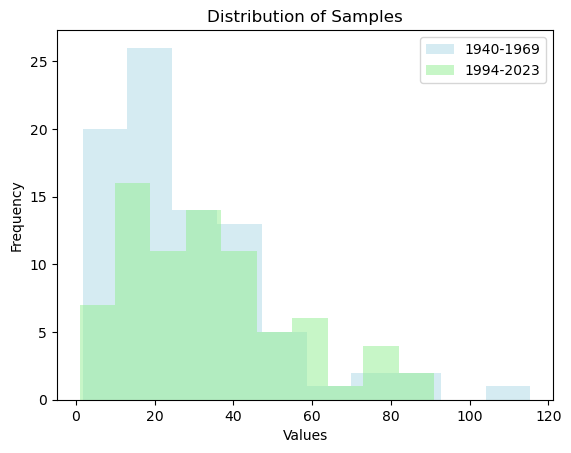

In [108]:
# Plot histograms
plt.hist(past_samples, alpha=0.5, label='1940-1969', color='lightblue')
plt.hist(present_samples, alpha=0.5, label='1994-2023', color='lightgreen')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Samples')
plt.show()

<xarray.DataArray 'DailyPrecip' ()>
array(33.306858, dtype=float32)
Coordinates:
    lat      float64 50.0
    lon      float64 200.0

In [91]:
rolling_total_precip_20yrs = compute_rolling_average_iterative(total_precip_da, window_years=30)

In [ ]:
# Plot three things:



In [93]:
import numpy as np

def bootstrap_significance_test(time_series, n_bootstraps=1000, alpha=0.05):
    """
    Assess the statistical significance of the difference between the first 
    and last value in a time series using bootstrapping.
    
    Parameters:
        time_series (array-like): 1D array of time series data.
        n_bootstraps (int): Number of bootstrap resamples to perform.
        alpha (float): Significance level for confidence interval (e.g., 0.05 for 95% CI).
        
    Returns:
        observed_diff (float): Observed difference between last and first values.
        lower_bound (float): Lower bound of the bootstrap confidence interval.
        upper_bound (float): Upper bound of the bootstrap confidence interval.
        p_value (float): p-value indicating the proportion of bootstrap samples 
                         with a more extreme difference than the observed difference.
    """
    # Convert to numpy array for easy manipulation
    time_series = np.array(time_series)
    
    # Calculate the observed difference
    observed_diff = time_series[-1] - time_series[0]
    
    # Perform bootstrapping
    bootstrapped_diffs = []
    for _ in range(n_bootstraps):
        # Create a bootstrap sample by sampling with replacement
        bootstrap_sample = np.random.choice(time_series, size=len(time_series), replace=True)
        # Compute the difference between the last and first value of the bootstrap sample
        bootstrapped_diff = bootstrap_sample[-1] - bootstrap_sample[0]
        bootstrapped_diffs.append(bootstrapped_diff)
    
    # Calculate the confidence interval
    lower_bound = np.percentile(bootstrapped_diffs, 100 * (alpha / 2))
    upper_bound = np.percentile(bootstrapped_diffs, 100 * (1 - alpha / 2))
    
    # Calculate the p-value: proportion of bootstrap differences more extreme than observed
    extreme_diffs = [diff for diff in bootstrapped_diffs if abs(diff) >= abs(observed_diff)]
    p_value = len(extreme_diffs) / n_bootstraps
    
    return observed_diff, lower_bound, upper_bound, p_value

In [95]:
# Example usage:
time_series = rolling_total_precip_20yrs.sel(lat=50,lon=200).values  # Replace with your time series data
observed_diff, lower_bound, upper_bound, p_value = bootstrap_significance_test(time_series)
print(f"Observed Difference: {observed_diff}")
print(f"95% CI: [{lower_bound}, {upper_bound}]")
print(f"P-value: {p_value}")

Observed Difference: 0.6232967376708984
95% CI: [-0.7189425945281982, 0.7046172618865966]
P-value: 0.14


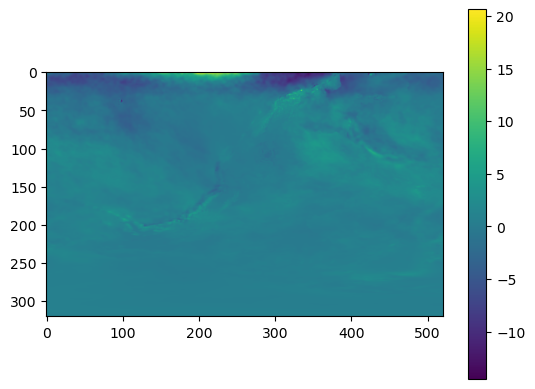

In [92]:
plt.imshow(rolling_total_precip_20yrs[-1] - rolling_total_precip_20yrs[0])
plt.colorbar()

In [79]:
rolling_total_precip_20yrs

<xarray.DataArray 'DailyPrecip' (year: 65, lat: 321, lon: 521)>
array([[[17.142124 , 16.91963  , 16.710026 , ..., 21.509188 ,
         21.52003  , 21.234322 ],
        [16.006716 , 15.722399 , 15.689874 , ..., 20.940796 ,
         21.008799 , 20.69425  ],
        [15.076129 , 14.929818 , 14.994665 , ..., 20.332813 ,
         20.21111  , 20.247057 ],
        ...,
        [ 2.123218 ,  2.123361 ,  2.124286 , ...,  2.4251974,
          2.425638 ,  2.426691 ],
        [ 2.220559 ,  2.2204642,  2.2207239, ...,  2.350542 ,
          2.350788 ,  2.350998 ],
        [ 2.263905 ,  2.263905 ,  2.263905 , ...,  2.263905 ,
          2.263905 ,  2.263905 ]],

       [[17.706446 , 17.44609  , 17.151575 , ..., 20.724075 ,
         20.721502 , 20.442867 ],
        [16.318672 , 15.956459 , 15.874543 , ..., 20.19203  ,
         20.236427 , 19.92891  ],
        [15.263579 , 15.087522 , 15.119243 , ..., 19.621181 ,
         19.484928 , 19.511366 ],
...
        [ 3.8777602,  3.8769526,  3.8772562, ...,  4.018715 ,
          4.019844 ,  4.021314 ],
        [ 4.0141797,  4.013649 ,  4.0132546, ...,  4.0210476,
          4.021088 ,  4.0212703],
        [ 4.0648193,  4.0648193,  4.0648193, ...,  4.0648193,
          4.0648193,  4.0648193]],

       [[17.83245  , 18.096819 , 18.103767 , ..., 17.030409 ,
         16.940567 , 16.676956 ],
        [16.668825 , 16.66365  , 16.423021 , ..., 16.80887  ,
         16.713335 , 16.877754 ],
        [15.004419 , 14.746059 , 14.879779 , ..., 16.520609 ,
         16.278376 , 16.09204  ],
        ...,
        [ 4.0561175,  4.055367 ,  4.0557227, ...,  4.177324 ,
          4.1786885,  4.180332 ],
        [ 4.187461 ,  4.186944 ,  4.1865897, ...,  4.1925726,
          4.1926455,  4.192839 ],
        [ 4.2290998,  4.2290998,  4.2290998, ...,  4.2290998,
          4.2290998,  4.2290998]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 10.0 10.25 10.5 10.75 11.0 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 180.0 180.2 180.5 180.8 ... 309.2 309.5 309.8 310.0
  * year     (year) int64 1959 1960 1961 1962 1963 ... 2019 2020 2021 2022 2023

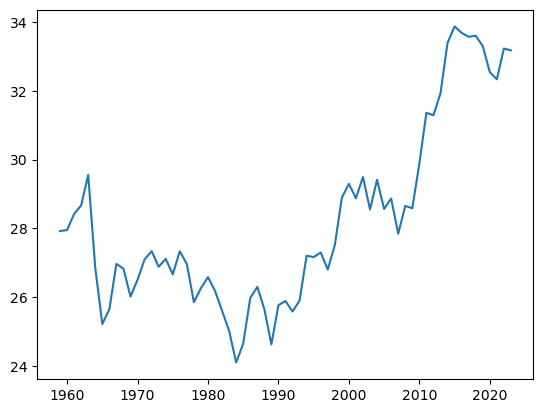

In [80]:
plt.plot(rolling_total_precip_20yrs.year,rolling_total_precip_20yrs.sel(lat=50,lon=200))